# Setup 

In [1]:
%matplotlib inline

import torch
import numpy as np
import pandas as pd
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.autograd import Variable
from torchvision import datasets, transforms

# Dataloaders

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       #transforms.Normalize((0.1307,), (0.3081,)) #normalise pixels using mean and stdev
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #normalise to range -1 to 1
                   ])



MNIST_train = datasets.MNIST(r'D:\Data_sets/MNIST', train=True, download=True,
                   transform=transform)

MNIST_test = datasets.MNIST(r'D:\Data_sets/MNIST', train=False, download=True,
                   transform=transform)

In [4]:
train_loader = torch.utils.data.DataLoader(MNIST_train, 
                                           batch_size=64, 
                                           shuffle=True, 
                                           pin_memory=True)

test_loader = torch.utils.data.DataLoader(MNIST_test,
                                          batch_size=1000, 
                                          shuffle=True, 
                                          pin_memory=True)

# ModelBuilders 

In [11]:
class Flatten(nn.Module):
    """Flattens input to vector size (batchsize, 1)
    (for use in NetFromBuildInfo)."""

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)

In [12]:
class NetFromBuildInfo(nn.Module):
    def __init__(self, build_info):
        super(NetFromBuildInfo, self).__init__()
        
        self.activation_dict = {
            'tanh': nn.Tanh(),
            'relu': nn.ReLU(),
            'sigmoid': nn.Sigmoid(),
            'elu': nn.ELU()
            }

        #NETWORK DEFINITION
        
        previous_units = 28 * 28 #MNIST shape
        
        self.model = nn.Sequential()
        self.model.add_module('flatten', Flatten())
         
        for i, layer_info in enumerate(build_info['layers']):
            i = str(i)
            
            self.model.add_module(
                'fc_' + i,
                nn.Linear(previous_units, layer_info['nb_units'])
                )
            
            previous_units = layer_info['nb_units']
            
            self.model.add_module(
                'dropout_' + i,
                nn.Dropout(p=layer_info['dropout_rate'])
                )
            if layer_info['activation'] == 'linear':
                continue #linear activation is identity function
            self.model.add_module(
                layer_info['activation']+ i,
                self.activation_dict[layer_info['activation']])

        self.model.add_module(
            'logits',
            nn.Linear(previous_units, 10) #10 MNIST classes
            )
        
        
        ##OPTIMIZER

        self.opt_args = {#'params': self.model.parameters(),
                 'weight_decay': build_info['weight_decay'],
                 'lr': build_info['lr']
                 }
        
        self.optimizer_dict = {
            'adam': optim.Adam(self.model.parameters(),**self.opt_args),
            'rmsprop': optim.RMSprop(self.model.parameters(),**self.opt_args),
            'adadelta':optim.Adadelta(self.model.parameters(),**self.opt_args),
            'sgd': optim.SGD(self.model.parameters(), **self.opt_args, momentum=0.9) #momentum to train faster
            }

        self.optimizer = self.optimizer_dict[build_info['optimizer']]
        
        
    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [37]:
def rebuild_from_save(df, generation, position):
    
    genome = df[df['Generation'] == generation].iloc[position, -2]
    
    net = NetFromBuildInfo(genome)
    
    net.load_state_dict(torch.load(r"D:\Models\NeuroEvolution\{}-{}".format(generation, position)))
    
    return net.cuda()

# Exploration

In [5]:
df = pd.read_pickle(r"../data/neuroevolution2")

In [24]:
df[df['Generation'] == 68]

,Generation,Clean,Adversarial,No_layers,Lr,Act_func,Nb_units,Dropout,Genome
2010,68,8811,8181,1,0.078663,linear,1577,0.673602,"{'optimizer': 'adam', 'weight_decay': 0.000168..."
2011,68,8997,8312,1,0.078663,linear,1577,0.673602,"{'optimizer': 'adam', 'weight_decay': 4.712941..."
2012,68,9099,8295,1,0.078663,linear,1577,0.673602,"{'optimizer': 'adam', 'weight_decay': 4.712941..."
2013,68,8755,8274,2,0.00463863,linear,1577,0.673602,"{'optimizer': 'adam', 'weight_decay': 4.712941..."
2014,68,8933,8223,1,0.078663,linear,1577,0.673602,"{'optimizer': 'adam', 'weight_decay': 0.000168..."
2015,68,980,980,1,0.078663,linear,1577,0.673602,"{'optimizer': 'sgd', 'weight_decay': 4.7129419..."
2016,68,9184,627,1,0.0664317,linear,1577,0.673602,"{'optimizer': 'adadelta', 'weight_decay': 0.00..."
2017,68,1108,3091,1,0.078663,tanh,1577,0.673602,"{'optimizer': 'adam', 'weight_decay': 4.712941..."
2018,68,9207,255,1,0.039763,linear,1577,0.212479,"{'optimizer': 'adadelta', 'weight_decay': 0.00..."
2019,68,7937,4600,1,0.078663,sigmoid,1822,0.673602,"{'optimizer': 'sgd', 'weight_decay': 4.7129419..."


In [30]:
popnums = [j for i in range(100) for j in range(30)]

In [31]:
df['popnum'] = popnums

In [33]:
df[df['Adversarial'] == df['Adversarial'].max()]

,Generation,Clean,Adversarial,No_layers,Lr,Act_func,Nb_units,Dropout,Genome,popnum
2032,68,9112,8577,1,0.078663,linear,1577,0.673602,"{'optimizer': 'rmsprop', 'weight_decay': 4.712...",22


In [78]:
df[df['Adversarial'] == df['Adversarial'].max()].iloc[0,-2]

{'layers': [{'activation': 'linear',
   'dropout_rate': 0.6736020681051939,
   'nb_units': 1577}],
 'lr': 0.07866303147789494,
 'nb_layers': 1,
 'optimizer': 'rmsprop',
 'weight_decay': 4.712941984142251e-05}

In [39]:
model = rebuild_from_save(df, 68, 22)

In [40]:
model

NetFromBuildInfo(
  (model): Sequential(
    (flatten): Flatten()
    (fc_0): Linear(in_features=784, out_features=1577, bias=True)
    (dropout_0): Dropout(p=0.6736020681051939)
    (logits): Linear(in_features=1577, out_features=10, bias=True)
  )
)

In [47]:
count_parameters(model)

1253725

In [221]:
def importances(label):
    pixel_importances = []
    for i in range(784):
        first_layer = layer1[:, i] + biases1
        second_layer = first_layer * layer2[label:, ] + biases2[label]
        pixel_importances.append(second_layer.sum())
    pixel_importances = np.array(pixel_importances).reshape(28,28)
    return pixel_importances

In [273]:
def importances_plotter(model):
    
    params = list(model.parameters())
    
    layer1 = params[0].detach().cpu().numpy()
    biases1 = params[1].detach().cpu().numpy()
    layer2 = params[2].detach().cpu().numpy()
    biases2 = params[3].detach().cpu().numpy()
    
    fig = plt.figure(figsize=(20,20))
    for i in range(10):
        ax = fig.add_subplot(4,3, i+1)
        im = importances(i)
        immer = ax.imshow(im, cmap='Reds')
        ax.text(x=8, y=32, s="Label: {}".format(i), fontsize=20)
        plt.colorbar(immer, ax=ax)

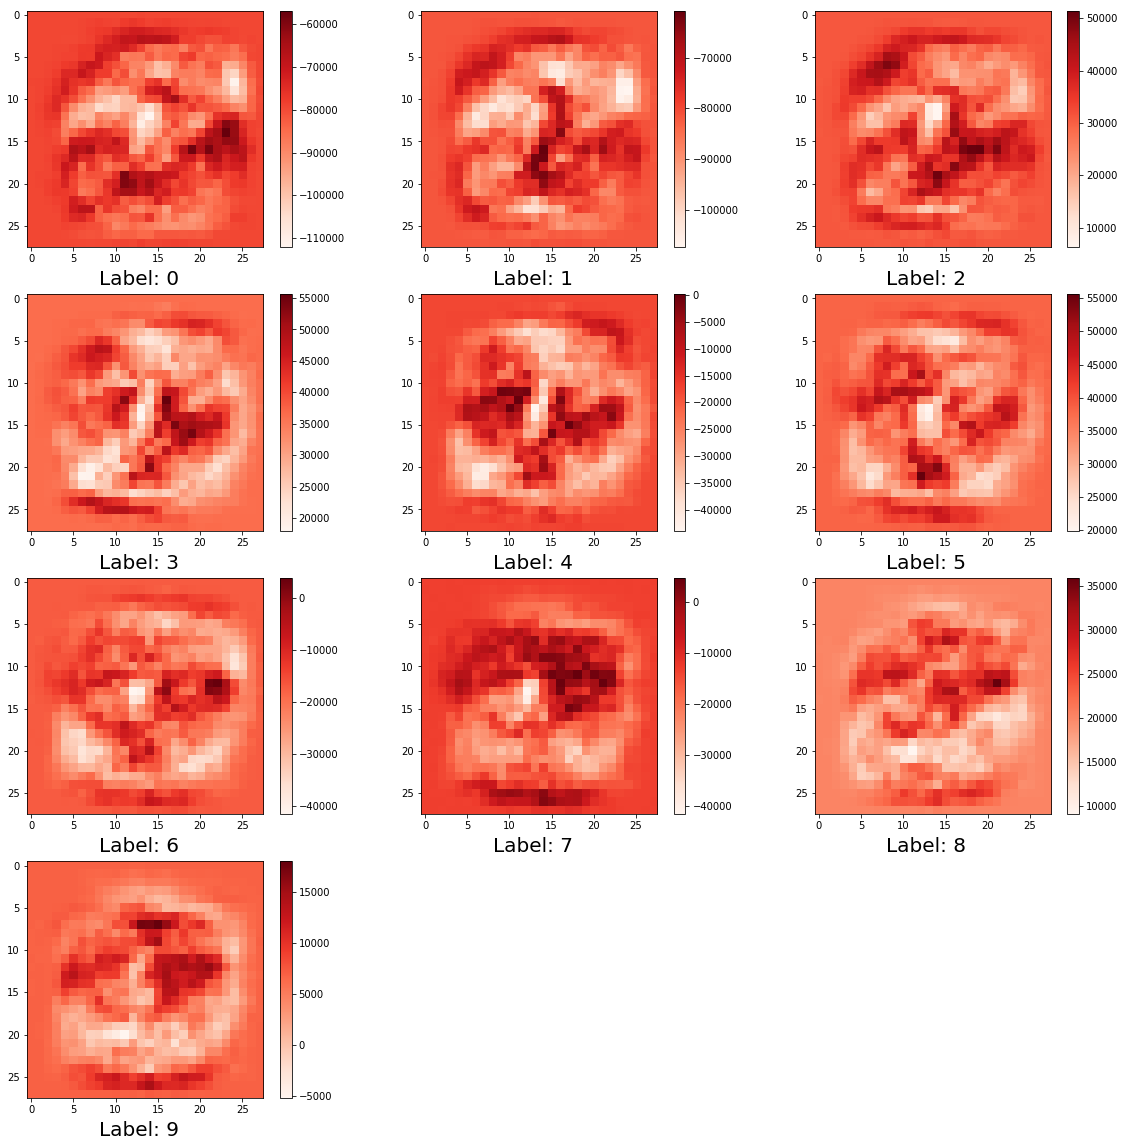

In [274]:
importances_plotter(model)